In [1]:
import numpy as np 
import commands
import os
import matplotlib.pyplot as plt

In [2]:
%pylab inline
from astropy.table import Table
import fitsio

Populating the interactive namespace from numpy and matplotlib


/Users/Ismael/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
#directories that would be using 
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/'
repo = '/Users/Ismael/code/lensing/repo/'

In [4]:
os.chdir(WLD)
width = 512 
height = 512
psf_beta = 3.0 
psf_e1 = 0. #when it is 0 then the sigma matches the fwhm. 
psf_e2 = 0. 
psf_fwhm = .7 
airmass = 1.
cd = 1.06502 #disk. 
cb = 10.8396 #bulge 

In [8]:
#produces demo.fits file with partials, 
cmd = ('./simulate.py --catalog-name OneDegSq.fits --image-width {0} --image-height {1} \
--survey-name LSST --filter-band i --output-name demo --verbose --calculate_bias \
--mirror-diameter 0 --atmospheric-psf-beta {2} --atmospheric-psf-e1 {3} --atmospheric-psf-e2 {4} \
--zenith-psf-fwhm {5} --no-bulge --no-agn --airmass {6} --truncate-radius 40').format(width,height,psf_beta,psf_e1,psf_e2,psf_fwhm,airmass)
output = commands.getoutput(cmd)
print output

Read 858502 catalog entries from OneDegSq.fits
Simulating LSST i-band survey with {'exposure_time': 6900.0, 'sky_brightness': 20.0, 'mirror_diameter': 0.0, 'airmass': 1.0, 'zero_point': 41.5, 'survey_name': 'LSST', 'image_width': 512, 'filter_band': 'i', 'pixel_scale': 0.2, 'atmospheric_psf_beta': 3.0, 'cosmic_shear_g2': 0.0, 'zenith_psf_fwhm': 0.7, 'image_height': 512, 'effective_area': 33.212, 'extinction': 0.07, 'atmospheric_psf_e1': 0.0, 'cosmic_shear_g1': 0.0, 'atmospheric_psf_e2': 0.0} (obs.frac. = 0.000)
Will render all pixels with at least 33.8 detected electrons.
PSF dilution factor is 0.051823.
Simulation output will be saved to demo.fits
a_d,b_d: 0.148655995727,0.0543344989419
identifier 2212292740
disk_q 0.365504927508
disk_hlr_arcsecs 0.0898729605751
bulge_hlr_acsecs None
beta_radians 3.59616602216
disk_flux 16991.3496104
self.cosmic_shear_g1 0.0
self.cosmic_shear_g2 0.0
a1: 0.173251885551
b1: 0.063324417869
sqrt(a1*b1) = hlr_d?: 0.104742898553
a_d,b_d: 0.190776392817,0.12

In [9]:
catalog = Table.read('demo.fits', hdu=1)
fits = fitsio.FITS('demo.fits')

In [10]:
#example particular columns and conditions out of the fits file. 
print catalog.colnames
selected = ((catalog['grp_size'] == 1) & (catalog['snr_grpf']>20) & (catalog['visible'] == 1))
selected_catalog = catalog[selected]
selected_catalog

['db_id', 'grp_id', 'grp_size', 'grp_rank', 'visible', 'xmin', 'xmax', 'ymin', 'ymax', 'f_disk', 'f_bulge', 'dx', 'dy', 'z', 'ab_mag', 'ri_color', 'flux', 'sigma_m', 'sigma_p', 'e1', 'e2', 'a', 'b', 'beta', 'psf_sigm', 'purity', 'snr_sky', 'snr_iso', 'snr_grp', 'snr_isof', 'snr_grpf', 'ds', 'dg1', 'dg2', 'ds_grp', 'dg1_grp', 'dg2_grp', 'hsm_sigm', 'hsm_e1', 'hsm_e2', 'g1_fit', 'g2_fit']


db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2202566474,2202566474,1,0,1,443,458,424,441,1.0,0.0,39.0118,35.3156,1.49478,24.5736,0.345329,168288.0,0.17844,0.276451,-0.63614,-0.0844522,0.381971,0.0833588,-1.5048,0.548753,1.0,31.6828,31.5414,31.5414,22.4396,22.4396,0.667772,0.661112,0.154985,0.667772,0.661112,0.154985,nan,nan,nan,0.0,0.0
402700759713,402700759713,1,0,1,229,250,246,267,1.0,0.0,-3.18475,0.16704,0.709124,23.0785,0.758797,669136.0,0.293939,0.295293,0.0585221,-0.0342084,0.314588,0.274646,-0.264487,0.565329,1.0,113.232,111.657,111.657,75.6882,75.6882,0.0296491,0.0280337,0.0278445,0.0296491,0.0280337,0.0278445,nan,nan,nan,0.0,0.0
402700632300,402700632300,1,0,1,165,187,344,392,1.0,0.0,-15.9555,22.4338,1.38524,22.5413,0.43375,1.04996e+06,0.734498,1.04044,-0.559721,0.146625,1.42162,0.379487,1.44269,0.959838,1.0,117.066,115.925,115.925,73.5155,73.5155,0.0232631,0.0205154,0.0104945,0.0232631,0.0205154,0.0104945,nan,nan,nan,0.0,0.0
402701063768,402701063768,1,0,1,80,105,472,491,1.0,0.0,-32.6268,45.1541,0.245936,23.6173,0.504986,407343.0,0.387852,0.45489,0.331939,0.218887,0.590773,0.254631,0.291484,0.644935,1.0,61.9365,61.5062,61.5062,40.6223,40.6223,0.055806,0.0475848,0.0403911,0.055806,0.0475848,0.0403911,nan,nan,nan,0.0,0.0
402702065908,402702065908,1,0,1,214,229,158,173,1.0,0.0,-6.77934,-18.0511,0.701308,24.3905,0.681112,186830.0,0.0573639,0.06256,0.0605771,-0.287794,0.0776696,0.0423668,-0.681669,0.486333,1.0,39.4768,39.2259,39.2259,29.8172,29.8172,1.18959,0.827521,1.22096,1.18959,0.827521,1.22096,nan,nan,nan,0.0,0.0
402701447366,402701447366,1,0,1,160,183,120,138,1.0,0.0,-16.846,-25.3246,1.44095,23.7838,0.51178,336943.0,0.325695,0.443226,0.453898,-0.304468,0.601496,0.176356,-0.295424,0.629226,1.0,54.4927,54.1375,54.1375,36.6114,36.6114,0.105568,0.0878773,0.0659716,0.105568,0.0878773,0.0659716,nan,nan,nan,0.0,0.0


In [11]:
import math 
os.chdir(repo)
import galfun
import fisher

In [127]:
for row in selected_catalog:
    galaxy_id = row['db_id']
    os.chdir(WLD)
    cmd = './fisher.py --i demo.fits -o notebooks/example.png --galaxy {0} --label-color white --no-display --bias --covariance'.format(galaxy_id)
    status,output = commands.getstatusoutput(cmd)
    print 'galaxy {0}:'.format(galaxy_id) 
    print 'WLD:'
    print output
    print
    os.chdir(repo)
#     g = (row['a'] - row['b'])/ (row['a'] + row['b'])
#     theta = math.atan2(row['e2'],row['e1'])
#     g1 = g*math.cos(theta)
#     g2 = g*math.sin(theta)
    e = math.sqrt(row['e1']**2 + row['e2']**2)
    hlr = row['sigma_m']*math.sqrt(1 - e**2)/math.sqrt(cd) #look at appendix of David's paper. 
    project_name = 'project'
    snr = row['snr_sky']
    cmd = ('python generate.py -p {0} -gal 1 --psf_model psf_moffat --galaxy-model exponential --g1 {1} --g2 {2} --y0 0 --x0 0 '
            '--flux {3} --psf_flux 1. --hlr {4} --psf_fwhm {5} --snr {6} --psf_beta {7}').format(project_name,row['e1'],row['e2'],row['flux'],hlr,psf_fwhm,snr,psf_beta)
    output = commands.getoutput(cmd)
    g_parameters = galfun.GParameters(project_name)
    print 
    fish = fisher.Fisher(g_parameters=g_parameters, snr=float(snr))
    print 'repo:'
    for param in fish.biases:
        std = math.sqrt(fish.covariance_matrix[param,param])
        bias = fish.biases[param]
        print param
        print 'value: {0}'.format(g_parameters.params[param])
        print 'std: {0}'.format(std)
        print 'bias: {0}'.format(bias)
        print 'bias/std: {0}'.format(bias/std)
    print


galaxy 2202566474:
WLD:
flux
std: 7499.59911691
bias: 532.180606803
bias/std: 0.0709612071935
x
std: 0.0160113229203
bias: -1.40877160593e-06
bias/std: -8.79859592453e-05
y
std: 0.0201219322545
bias: -1.05596210958e-06
bias/std: -5.24781664218e-05
s
std: 0.667771829152
bias: -0.676956059
bias/std: -1.01375354492
g1
std: 0.661111985436
bias: -0.874473357754
bias/std: -1.32273106073
g2
std: 0.154985429776
bias: -0.116049589173
bias/std: -0.748777413078


repo:
hlr_1
value: 0.132608785469
std: 0.0882893285999
bias: -0.0892965942621
bias/std: -1.01140869093
g2_1
value: -0.0844522193074
std: 0.187162892118
bias: -0.0441379621625
bias/std: -0.23582645931
g1_1
value: -0.636140167713
std: 0.388494874088
bias: -0.331588029861
bias/std: -0.853519703805
x0_1
value: 0.0
std: 0.0157917920254
bias: 2.46791751124e-06
bias/std: 0.000156278496277
flux_1
value: 168288.265625
std: 7482.15744518
bias: 538.961486816
bias/std: 0.0720328983672
y0_1
value: 0.0
std: 0.0199290198116
bias: -6.17979094386e-06
bia

## Example demonstrating David's code on moments

In [ ]:
import math 
from descwl.model import moments_size_and_shape
from descwl.model import sersic_second_moments
#got entry from exponential galaxy in the table 
n = 1 #sersic index 
e1 = -0.559721
e2 = 0.146625
a = 0.945682
b = 0.25244
hlr = math.sqrt(a*b) #should be sigma_m, 0.488598
q = b/a
beta = .5*math.atan2(e2,e1) #should be beta in table, 1.44269
emag1 = math.sqrt(e1**2 + e2**2)
emag2 = (1. - q)/(1. + q)
assert round(emag1,3) == round(emag2,3), "input a,b not consistent with e1,e2"
print "input values are (in order): hlr, q, beta, e1,e2,a,b:\n",hlr,q,beta,e1,e2,a,b
print
Q = sersic_second_moments(n,hlr,q,beta)
sigma_m,sigma_p,a1,b1,beta1,e11,e21 = moments_size_and_shape(Q)
hlr1 = math.sqrt(a1*b1)
q1 = b1/a1
print "output values are (in order): hlr, q, beta,e1,e2,a, b:\n",hlr1,q1,beta1,e11,e21,a1,b1

### Manual checking by entries by forcing what I think are the correct values (look at table above) 

In [5]:
import math 
os.chdir(repo)
import galfun
import fisher

In [7]:
# a = 0.945682
# b = 0.25244
#all gotten from the table except a_d, b_d, disk_hlr_arcsecs
galaxy_id = 402700632300
e1 = -0.559721 #in David's this is g1,g2 of Galsim. 
e2 = 0.146625
a_d = 1.12353277206
b_d = 0.299915492535
q_d = b_d/a_d #0.266939692364
disk_hlr_arcsecs = 0.58048676532 #sqrt(a_d*b_d) 
flux = 1049961.07539
beta = 1.44269468309
snr = 117.066 ## snr_sky
psf_fwhm = .7   #these were determined by me at the beginning. 
psf_beta = 3.0 
project_name = 'project11'
os.chdir(WLD)
cmd = './fisher.py --i demo.fits -o notebooks/example.png --galaxy {0} --label-color white --no-display --bias --covariance'.format(galaxy_id)
status,output = commands.getstatusoutput(cmd)
print 'galaxy {0}:'.format(galaxy_id) 
print 'WLD:'
print output
print
os.chdir(repo)
cmd = ('python generate.py -p {0} -gal 1 --psf_model psf_moffat --galaxy-model exponential --g1 {1} --g2 {2} --y0 0 --x0 0 '
        '--flux {3} --psf_flux 1. --hlr {4} --psf_fwhm {5} --snr {6} --psf_beta {7}').format(
        project_name,e1,e2,flux,disk_hlr_arcsecs,psf_fwhm,snr,psf_beta)

output = commands.getoutput(cmd)
print output
g_parameters = galfun.GParameters(project_name)
print 
fish = fisher.Fisher(g_parameters=g_parameters, snr=float(snr))
print 'repo:'
for param in fish.biases:
    std = math.sqrt(fish.covariance_matrix[param,param])
    bias = fish.biases[param]
    print param
    print 'value: {0}'.format(g_parameters.params[param])
    print 'std: {0}'.format(std)
    print 'bias: {0}'.format(bias)
    print 'bias/std: {0}'.format(bias/std)
print

galaxy 402700632300:
WLD:
flux
std: 14282.1767251
bias: 179.348445367
bias/std: 0.0125575007802
x
std: 0.00576126793211
bias: 7.66134411453e-10
bias/std: 1.32980173892e-07
y
std: 0.0116551954687
bias: -5.11666031981e-09
bias/std: -4.39002531836e-07
s
std: 0.0232631067695
bias: -0.000471679248495
bias/std: -0.0202758493596
g1
std: 0.0205154428054
bias: -0.000624405726811
bias/std: -0.0304358883566
g2
std: 0.0104945368282
bias: 0.000163657972676
bias/std: 0.0155945874845



repo:
hlr_1
value: 0.58048676532
std: 0.0141403296761
bias: -0.000239932385739
bias/std: -0.0169679485016
g2_1
value: 0.146625
std: 0.0133655252768
bias: 4.82889809064e-05
bias/std: 0.00361295047567
g1_1
value: -0.559721
std: 0.0144350130528
bias: -0.000186844539712
bias/std: -0.0129438427959
x0_1
value: 0.0
std: 0.00567508806146
bias: -8.13954102341e-07
bias/std: -0.000143425810054
flux_1
value: 1049961.07539
std: 15881.158846
bias: 277.786560059
bias/std: 0.0174915799756
y0_1
value: 0.0
std: 0.011753445699
bias: -8.

In [14]:
# I am now going to do a pixel by pixel comparison to figure out differences. 
entry = 0 
#find corresponding entry 
for i,elem in enumerate(fits[1]):
    if elem[0] == 402700632300: 
        entry = i
        for j,e in enumerate(elem): 
            print catalog.colnames[j]+ ': ' + str(e)
#print
#print entry 


db_id: 402700632300
grp_id: 402700632300
grp_size: 1
grp_rank: 0
visible: 1
xmin: 165
xmax: 187
ymin: 344
ymax: 392
f_disk: 1.0
f_bulge: 0.0
dx: -15.9555
dy: 22.4338
z: 1.38524
ab_mag: 22.5413
ri_color: 0.43375
flux: 1.04996e+06
sigma_m: 0.734498
sigma_p: 1.04044
e1: -0.559721
e2: 0.146625
a: 1.42162
b: 0.379487
beta: 1.44269
psf_sigm: 0.959838
purity: 1.0
snr_sky: 117.066
snr_iso: 115.925
snr_grp: 115.925
snr_isof: 73.5155
snr_grpf: 73.5155
ds: 0.0232631
dg1: 0.0205154
dg2: 0.0104945
ds_grp: 0.0232631
dg1_grp: 0.0205154
dg2_grp: 0.0104945
hsm_sigm: nan
hsm_e1: nan
hsm_e2: nan
g1_fit: 0.0
g2_fit: 0.0


0.0
6354.89160156


(array([ 160.,   56.,   28.,   25.,    8.,   19.,    8.,    6.,    3.,
          10.,    3.,    8.,    2.,    8.,    0.,    2.,    0.,    6.,
           2.,    0.,    6.,    4.,    4.,    2.,    0.,    0.,    0.,
           0.,    4.,    0.,    1.,    3.,    0.,    0.,    2.,    3.,
           3.,    0.,    2.,    0.,    2.,    0.,    2.,    0.,    0.,
           0.,    0.,    0.,    1.,    1.,    1.,    1.,    0.,    1.,
           1.,    0.,    3.,    1.,    0.,    0.,    0.,    0.,    2.,
           0.,    2.,    0.,    0.,    0.,    0.,    0.,    1.,    1.,
           0.,    0.,    1.,    1.,    0.,    0.,    0.,    0.,    1.,
           1.,    0.,    0.,    0.,    0.,    1.,    1.,    2.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.]),
 array([    0.        ,    64.19082426,   128.38164852,   192.57247277,
          256.76329703,   320.95412129,   385.14494555,   449.33576981,
          513.52659407,   577.71741832,   641.90824258,   706.09906684,
 

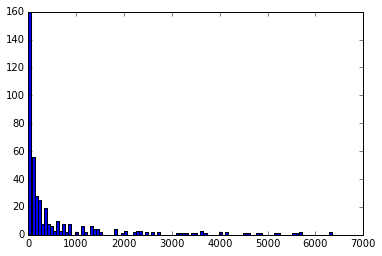

In [21]:
#compare histograms of both images, 
plt.figure()
print img_wld.min() 
print img_wld.max() 
plt.hist(img_wld.flatten(),np.linspace(img_wld.min(),img_wld.max(),num=100))

15.8814
14185.4


(array([ 118.,   38.,   24.,   20.,   10.,   12.,   10.,   12.,    8.,
           5.,    3.,    6.,    4.,    8.,    8.,   10.,    0.,   10.,
           0.,    2.,    6.,    4.,    0.,    6.,    4.,    2.,    4.,
           4.,    2.,    6.,    4.,    2.,    2.,    0.,    0.,    2.,
           2.,    2.,    2.,    0.,    4.,    0.,    2.,    2.,    2.,
           0.,    0.,    2.,    4.,    0.,    6.,    2.,    0.,    0.,
           0.,    0.,    2.,    0.,    2.,    2.,    0.,    0.,    0.,
           2.,    0.,    0.,    0.,    0.,    6.,    0.,    0.,    0.,
           0.,    0.,    0.,    4.,    0.,    2.,    2.,    0.,    0.,
           2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,
           0.,    0.,    2.,    0.,    0.,    0.,    0.,    2.,    2.]),
 array([    15.88140678,    159.00764415,    302.13388152,    445.26011889,
           588.38635626,    731.51259363,    874.63883099,   1017.76506836,
          1160.89130573,   1304.0175431 ,   1447.14378047,   1590

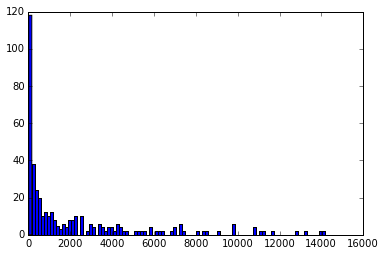

In [16]:
f = fish.image.array
plt.figure()
print f.min()
print f.max()
plt.hist(f.flatten(),np.linspace(f.min(),f.max(),num=100))

model_p
(19, 22)
14609.5
16.7908

galaxy_profile_p
(19, 22)
0.0995845
33808.7

galaxy_model_p
(19, 22)
-0.00129466
0.001467

psf_model_p
(19, 22)
9.29748e-06
0.0461182

final_p
(401, 401)
-0.000655833
2914.07

datacube_image
0.0
6354.89160156
(19, 22)


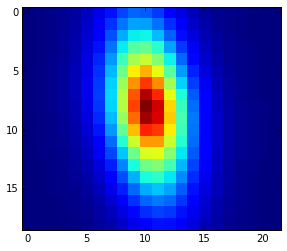

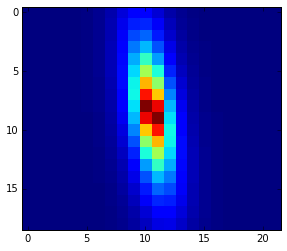

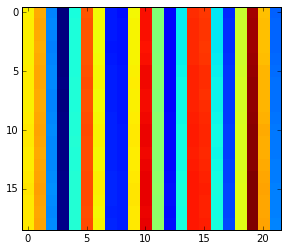

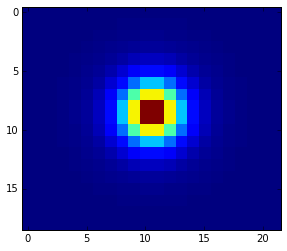

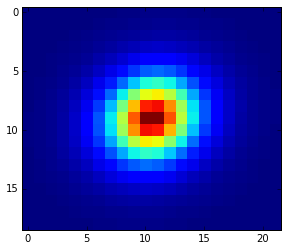

In [17]:
import pickle 
#use pickled wld image 
os.chdir(WLD)
model_p = (pickle.load(open("model.p","rb"))).array
galaxy_model_p = (pickle.load(open("galaxy_model.p","rb"))).array
galaxy_profile_p = (pickle.load(open("galaxy_profile.p","rb"))).array
psf_model_p = (pickle.load(open("psf_model.p","rb"))).array 
final_p = (pickle.load(open("final.p","rb"))).array 
print 'model_p'
print model_p.shape
print model_p.max() 
print model_p.min()
plt.figure()
plt.imshow(model_p)
print 
print 'galaxy_profile_p'
print galaxy_profile_p.shape
print galaxy_profile_p.min()
print galaxy_profile_p.max() 
plt.figure()
plt.imshow(galaxy_profile_p)
print
print 'galaxy_model_p'
print galaxy_model_p.shape
print galaxy_model_p.min()
print galaxy_model_p.max()
plt.figure()
plt.imshow(galaxy_model_p)
print
print 'psf_model_p'
print psf_model_p.shape
print psf_model_p.min()
print psf_model_p.max()
plt.figure()
plt.imshow(psf_model_p)
print
print 'final_p'
print final_p.shape
print final_p.min()
print final_p.max()
plt.figure()
plt.imshow(final_p)
print 
print 'datacube_image'
img_wld = fits[entry].read()[0]
print img_wld.min()
print img_wld.max()
print img_wld.shape
plt.imshow(img_wld)

16.7908
14609.5


(array([ 118.,   42.,   23.,   16.,   16.,    9.,   12.,    5.,    9.,
          10.,    5.,    6.,   10.,    2.,    6.,    4.,    4.,    8.,
           6.,    2.,    1.,    5.,    6.,    6.,    2.,    2.,    0.,
           3.,    4.,    3.,    4.,    1.,    3.,    2.,    0.,    4.,
           2.,    2.,    1.,    3.,    1.,    3.,    2.,    0.,    2.,
           0.,    2.,    1.,    2.,    0.,    3.,    0.,    1.,    1.,
           2.,    0.,    2.,    0.,    2.,    1.,    1.,    1.,    2.,
           0.,    1.,    1.,    0.,    1.,    1.,    0.,    1.,    1.,
           0.,    2.,    1.,    1.,    0.,    0.,    1.,    0.,    0.,
           1.,    1.,    0.,    2.,    1.,    1.,    0.,    0.,    0.,
           0.,    2.,    0.,    0.,    1.,    1.,    0.,    0.,    1.]),
 array([    16.79080009,    164.1914395 ,    311.59207891,    458.99271832,
           606.39335773,    753.79399714,    901.19463655,   1048.59527596,
          1195.99591536,   1343.39655477,   1490.79719418,   1638

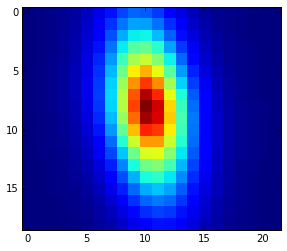

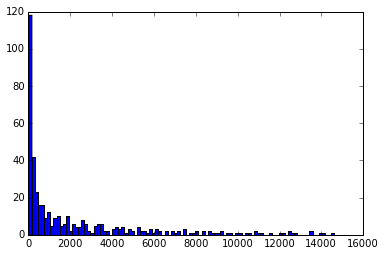

In [18]:
plt.figure()
print model_p.min() 
print model_p.max() 
plt.figure()
plt.imshow(model_p)
plt.figure()
plt.hist(model_p.flatten(),np.linspace(model_p.min(),model_p.max(),num=100))

(19, 22)
14185.4
15.8814


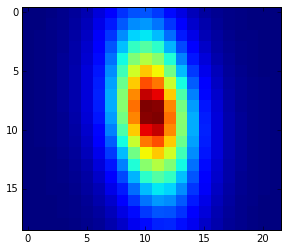

In [19]:
f = fish.image.array
print f.shape
print f.max() 
print f.min()
plt.figure()
plt.imshow(f)
#plt.figure()
#plt.hist(f.flatten(),np.linspace(f.min(),f.max(),num=100))

In [20]:
#print galaxy. model information and use repr for each case, 